In [1]:
%%capture
# ! pip install -q git+https://github.com/EfficientDL/codelab_utils.git
# !pip install tensorflow-model-optimization

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot
import ipywidgets as ipyw

from pathlib import Path
from tensorflow.keras import layers, optimizers, metrics, losses, models
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model, array_to_img
from matplotlib import pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [82]:
%%capture
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'oxford_flowers102',
    with_info=True,
    split=['train', 'validation', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 3/3 [05:25<00:00, 135.74s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:29<00:00, 109.76s/ url]


Dataset oxford_flowers102 downloaded and prepared to /Users/broxoli/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [84]:
# Dataset image size
IMG_SIZE = 264

def preprocess(item):
    image, label = item['image'], item['label']
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    return image, label

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

## Make Triplets

In [142]:
N_CLASSES = 102
SHUFFLE_BUFFER_SIZE = 500

def make_triplets(ds):
    all_triplets = None

    def pick_image(image, label): return image
    # def pick_image(image, label): return (image, label)

    for idx in range(N_CLASSES):
        anchor_ds = ds.filter(lambda _,y: y == idx).map(pick_image)
        positive_ds = anchor_ds.shuffle(SHUFFLE_BUFFER_SIZE)
        negative_ds = ds.filter(lambda _,y: y != idx).map(pick_image)
        triplet_ds = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds))
        triplet_ds = triplet_ds.map(lambda x,y,z: tf.stack([x, y, z], axis=0))
        triplet_ds = tf.data.Dataset.zip((triplet_ds, ds.map(lambda x,y: 0)))

        all_triplets = triplet_ds if not all_triplets else all_triplets.concatenate(triplet_ds)
    
    return all_triplets
    
train_triplet_ds = make_triplets(
    train_prep_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True)
)

0


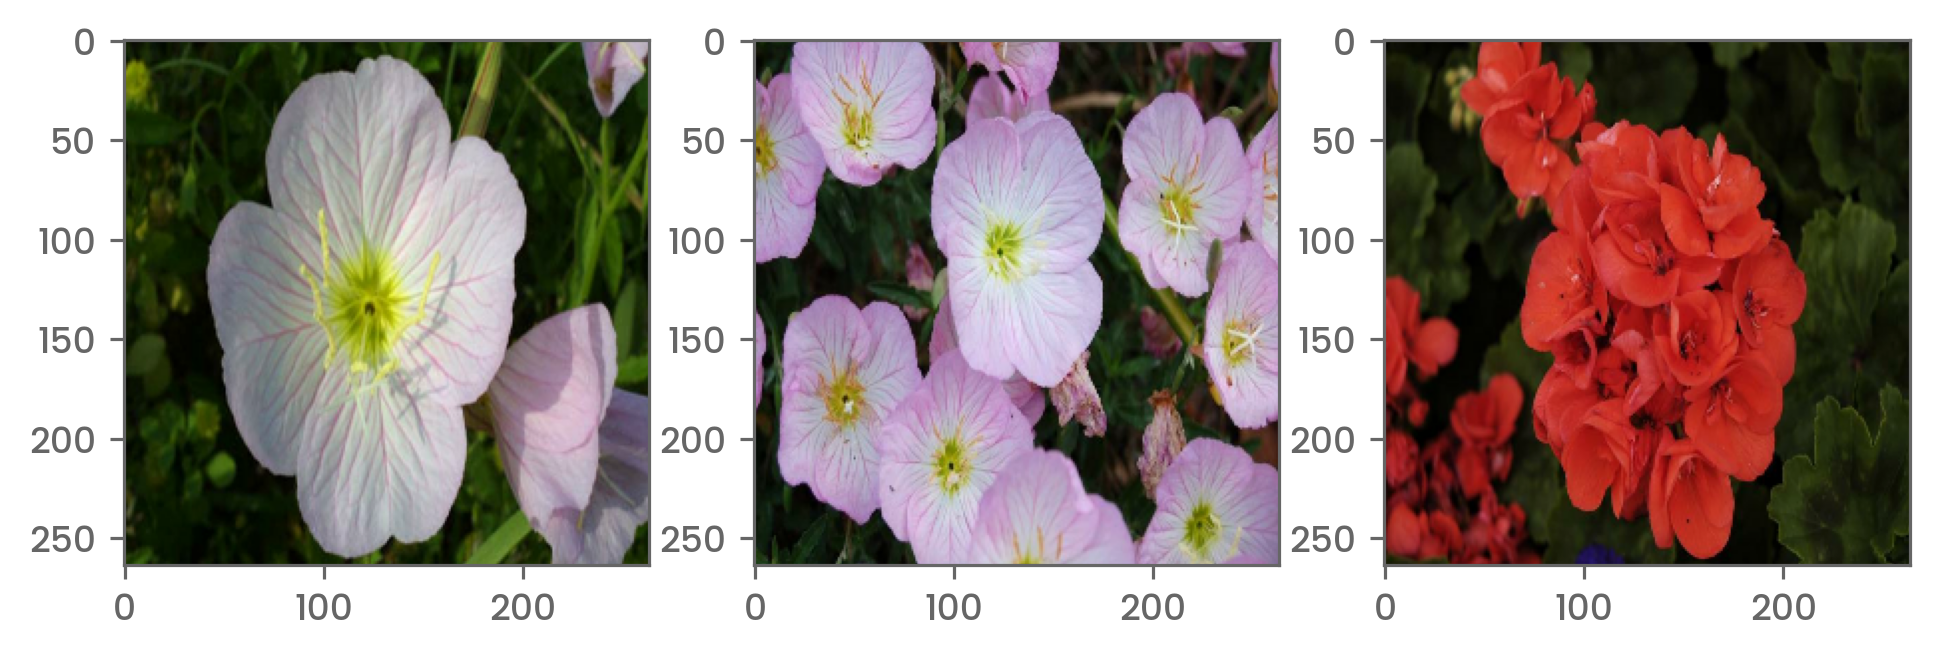

In [146]:
itr = train_triplet_ds.shuffle(10).as_numpy_iterator()
(anchor, positive, negative), label = next(itr)
# (anchor, a_label), (positive, p_label), (negative, n_label) = next(itr)

def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, image in enumerate(display_list):
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(display_list[index]))

display([anchor, positive, negative], cols=3)
print(label)
# print(a_label, p_label, n_label)

In [156]:
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002
DELTA = 0.5

def triplet_loss(_, features):
  print(features)
  anchor, positive, negative = tf.unstack(features, axis=1)
  batch_size = tf.shape(anchor)[0]

  # Compute the distances of anchor from the positive and the negative samples
  positive_dist = tf.norm(anchor-positive, axis=-1)
  negative_dist = tf.norm(anchor-negative, axis=-1)

  print(tf.shape(positive_dist), tf.shape(tf.repeat(DELTA, repeats=batch_size, axis=0)))

  loss = tf.maximum(0., positive_dist-negative_dist+tf.repeat(DELTA, repeats=batch_size, axis=0))

  return loss

def create_contrastive_learning_model():
  # Initalize the core model
  core_args = dict(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
  core = apps.resnet50.ResNet50(**core_args)
  # core.trainable = False

  # Setup the top
  features = tf.keras.Sequential(
    [
      # layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      # layers.Lambda(lambda x: tf.cast(x, tf.float32)),
      layers.Lambda(lambda x: apps.resnet.preprocess_input(x)),
      core,
      layers.Flatten(),
      # layers.Dropout(DROPOUT_RATE),
      # layers.Dense(N_CLASSES, activation='softmax')
    ],
    name='features'
  )

  # Triplet Inputs
  triplet = layers.Input([3, IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8)
  anchor, positive, negative = tf.unstack(triplet, axis=1)
  output = tf.stack([features(anchor), features(positive), features(negative)], axis=1)

  model = tf.keras.Model(inputs=[triplet], outputs=output)
  adam = optimizers.Adam(learning_rate=LEARNING_RATE)

  model.compile(optimizer=adam, loss=triplet_loss)
  return model

cl_model = create_contrastive_learning_model()
cl_model.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 3, 264, 264  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.unstack_8 (TFOpLambda)      [(None, 264, 264, 3  0           ['input_47[0][0]']               
                                ),                                                                
                                 (None, 264, 264, 3                                               
                                ),                                                                
                                 (None, 264, 264, 3                                        

In [162]:
for item in train_triplet_ds.batch(2).take(1):
    anchor, positive, negative = tf.unstack(item[0], axis=1)
    print(layers.RandomRotation(0.1)(layers.RandomFlip("horizontal")(anchor)))
    print(layers.RandomFlip("horizontal")(anchor))
    
    # print(item[0].shape, item[1].shape)

tf.Tensor(
[[[[130.  94. 107.]
   [131.  93. 106.]
   [133.  96. 105.]
   ...
   [ 16.  26.   3.]
   [ 17.  26.  10.]
   [ 24.  39.   8.]]

  [[108.  70.  83.]
   [107.  70.  80.]
   [108.  68.  76.]
   ...
   [  9.  19.   0.]
   [ 18.  28.   4.]
   [ 26.  42.   8.]]

  [[ 99.  62.  69.]
   [ 96.  59.  66.]
   [ 94.  55.  59.]
   ...
   [ 10.  24.   0.]
   [ 17.  30.   0.]
   [ 27.  45.   6.]]

  ...

  [[ 30.  72.   2.]
   [ 42.  87.  13.]
   [ 25.  74.   0.]
   ...
   [ 39.  84.   0.]
   [ 47.  91.   0.]
   [ 56. 103.   5.]]

  [[ 30.  73.   3.]
   [ 37.  82.  12.]
   [ 32.  79.   7.]
   ...
   [ 38.  88.   0.]
   [ 50.  97.   2.]
   [ 54. 102.   2.]]

  [[ 27.  70.   1.]
   [ 36.  81.  12.]
   [ 34.  81.   9.]
   ...
   [ 44.  94.   5.]
   [ 52.  99.   4.]
   [ 50.  98.   0.]]]


 [[[ 60.  64.  30.]
   [115. 115.  91.]
   [169. 167. 153.]
   ...
   [123. 121. 122.]
   [122. 120. 121.]
   [121. 119. 120.]]

  [[ 43.  51.  13.]
   [ 91.  95.  66.]
   [133. 135. 115.]
   ...
   [122. 1

In [148]:
# # cl_model.load_weights('contrastive_learning_model.h5')
# CONTRASTIVE_LEARNING_MODEL = 'contrastive_learning_model.h5'

# ! wget "https://www.dropbox.com/s/bbv4dakqg45ctty/contrastive_learning_model.h5?dl=1" -O $CONTRASTIVE_LEARNING_MODEL

--2022-08-10 14:09:43--  https://www.dropbox.com/s/bbv4dakqg45ctty/contrastive_learning_model.h5?dl=1
A resolver www.dropbox.com (www.dropbox.com)... 162.125.81.18
A ligar a www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... ligado.
Pedido HTTP enviado, a aguardar resposta... 301 Moved Permanently
Localização: /s/dl/bbv4dakqg45ctty/contrastive_learning_model.h5 [a seguir]
--2022-08-10 14:09:44--  https://www.dropbox.com/s/dl/bbv4dakqg45ctty/contrastive_learning_model.h5
A reutilizar ligação existente a www.dropbox.com:443.
Pedido HTTP enviado, a aguardar resposta... 302 Found
Localização: https://uca743c4ae253c5a3309f6532103.dl.dropboxusercontent.com/cd/0/get/Bquj2fGaxAg0Bvie_3hajz0eM94QfM7_UQWms2gi04SphcxO3z89OAEv2cPA3wOS4UVwOeS9vcDJTPin-F3ls2Mh3mX5DOcEhKkkL-UA81M10EV_F9umeIGNZgbngsTO31TG7U9-hE6kaa6VcXxP4qRSvQnv5udQ-Fu-GqX6BGpVMQ/file?dl=1# [a seguir]
--2022-08-10 14:09:44--  https://uca743c4ae253c5a3309f6532103.dl.dropboxusercontent.com/cd/0/get/Bquj2fGaxAg0Bvie_3hajz0eM94QfM7_U

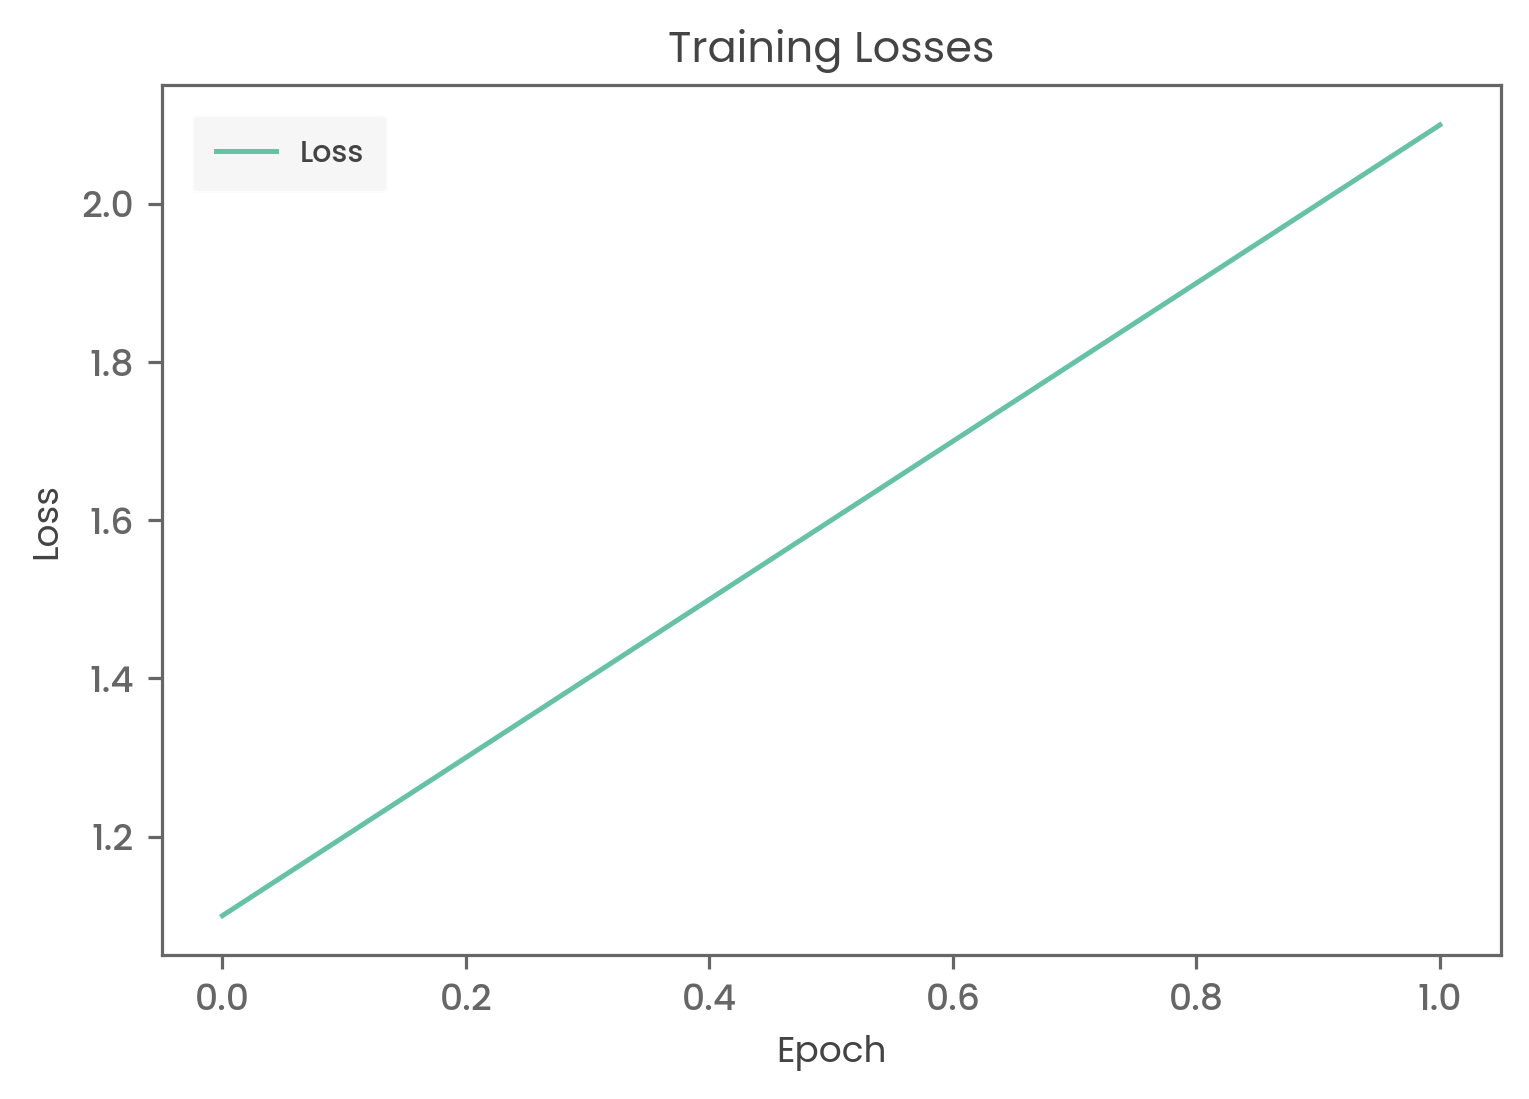

In [170]:
def plot_loss(h):
    fig = plt.figure()
    ax = fig.gca()

    ax.plot(h['loss'], label='Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Losses')

    ax.legend()

In [155]:
BATCH_SIZE = 24
EPOCHS = 30
# BATCH_SIZE = 2
# EPOCHS = 1
CONTRASTIVE_LEARNING_MODEL = 'contrastive_learning_model.h5'

# if not Path(CONTRASTIVE_LEARNING_MODEL).exists():
#     ! wget "https://www.dropbox.com/s/bbv4dakqg45ctty/contrastive_learning_model.h5?dl=1" -O $CONTRASTIVE_LEARNING_MODEL

#     print('Loading the pre-trained contrastive learning model...')
#     cl_model.load_weights(CONTRASTIVE_LEARNING_MODEL)

print('Training the contrastive learning model')
hist = cl_model.fit(train_triplet_ds.batch(BATCH_SIZE), epochs=EPOCHS)
plot_loss(hist.history), print(hist.history)

print('Saving the constrastive learning model as:', CONTRASTIVE_LEARNING_MODEL)
cl_model.save_weights(CONTRASTIVE_LEARNING_MODEL)

Loading the pre-trained contrastive learning model...


In [116]:
def create_classification_model(core):
    core.trainable = False

    inp = layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8)
    head = tf.keras.Sequential([
            layers.Dropout(DROPOUT_RATE),
            layers.Dense(N_CLASSES, activation='softmax')
        ],
        name='classification_head')

    features = core(inp)
    output = head(features)

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss='sparse_categorical_crossentropy'
    metrics=['accuracy']

    model = tf.keras.Model(inputs=[inp], outputs=output)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

    return model

classifier = create_classification_model(cl_model.layers[2])
classifier.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 264, 264, 3)]     0         
                                                                 
 features (Sequential)       (None, 165888)            23587712  
                                                                 
 classification_head (Sequen  (None, 102)              16920678  
 tial)                                                           
                                                                 
Total params: 40,508,390
Trainable params: 16,920,678
Non-trainable params: 23,587,712
_________________________________________________________________
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 264, 264, 3)]     0         
                   

In [149]:
# BATCH_SIZE = 24
# EPOCHS = 10
BATCH_SIZE = 2
EPOCHS = 1
CLASSIFIER_MODEL = 'classifier_model.h5'

# tds = train_prep_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).take(1)
# vds = val_prep_ds.batch(256).cache().take(1)
tds = train_prep_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

# Save the best weights during training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

classifier.fit(tds, validation_data=vds, epochs=EPOCHS, callbacks=[early_stopping])

print('Saving the classifier model as:', CLASSIFIER_MODEL)
classifier.save(CLASSIFIER_MODEL)
classifier.evaluate(test_prep_ds.batch(256))

1/1 [==============================] - ETA: 0s - loss: 9.1967 - accuracy: 0.5000

2022-08-10 14:24:47.441890: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 29s 29s/step - loss: 9.1967 - accuracy: 0.5000 - val_loss: 8.4275 - val_accuracy: 0.3008


<function print>